In [1]:
%%time

# Importing some of the necessary libraries

import json
from pathlib import Path
import time
import torch
from torch.utils.data import DataLoader

CPU times: user 1.03 s, sys: 162 ms, total: 1.19 s
Wall time: 2.71 s


In [2]:
%%capture

!pip install transformers

In [3]:
%%time

# Retrieval and Storage of the Data

def generate_texts_queries_answers(path):
    with open(path, 'rb') as f:
        squad_dict = json.load(f)
    texts, queries, answers = [], [], []
    for group in squad_dict['data']:
        for passage in group['paragraphs']:
            context = passage['context']
            for qa in passage['qas']:
                question = qa['question']
                for answer in qa['answers']:
                    texts.append(context)
                    queries.append(question)
                    answers.append(answer)
    return texts, queries, answers
    

train_path = Path('../input/stanford-question-answering-dataset/train-v1.1.json')
train_texts, train_queries, train_answers = generate_texts_queries_answers(train_path)
validation_path = Path('../input/stanford-question-answering-dataset/dev-v1.1.json')
validation_texts, validation_queries, validation_answers = generate_texts_queries_answers(validation_path)

CPU times: user 650 ms, sys: 135 ms, total: 785 ms
Wall time: 1.41 s


In [4]:
%%time

# Checking the lengths of the 6 lists obtained above

print (len(train_texts))
print (len(train_queries))
print (len(train_answers))

print (len(validation_texts))
print (len(validation_queries))
print (len(validation_answers))

87599
87599
87599
34726
34726
34726
CPU times: user 202 µs, sys: 26 µs, total: 228 µs
Wall time: 219 µs


In [5]:
%%time

# Checking the 1st entry in each of the 3 train datasets

print ('Text :\n', train_texts[0])
print ('\nQuestion :\n', train_queries[0])
print ('\nAnswer :\n', train_answers[0])

Text :
 Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.

Question :
 To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?

Answer :
 {'answer_start': 515, 'text': 'Saint Bernadette Soubirous'}
CPU times: user 103 µs, sys: 13 µs, total: 116 µs
Wall time: 109 µs


In [6]:
%%time

'''
Fixing up end position characters in train and validation data - Processing the SQuAD dataset to keep up with 
the input that BERT desires!
BERT Models need both the start and end position characters of the answer and sometimes its been noticed that 
SQuAD answers "eat up" 1 or 2 characters from the real answer in the passage
'''

# Train Data
for answer, text in zip(train_answers, train_texts):
    real_answer = answer['text']
    answer_start_index = answer['answer_start']
    answer_end_index = answer_start_index + len(real_answer)
    if text[answer_start_index : answer_end_index] == real_answer:
        answer['answer_end'] = answer_end_index
    elif text[answer_start_index - 1 : answer_end_index - 1] == real_answer:
        answer['answer_start'] = answer_start_index - 1
        answer['answer_end'] = answer_end_index - 1
    elif text[answer_start_index - 2 : answer_end_index - 2] == real_answer:
        answer['answer_start'] = answer_start_index - 2
        answer['answer_end'] = answer_end_index - 2
    
# Validation Data
for answer, text in zip(validation_answers, validation_texts):
    real_answer = answer['text']
    answer_start_index = answer['answer_start']
    answer_end_index = answer_start_index + len(real_answer)
    if text[answer_start_index : answer_end_index] == real_answer:
        answer['answer_end'] = answer_end_index
    elif text[answer_start_index - 1 : answer_end_index - 1] == real_answer:
        answer['answer_start'] = answer_start_index - 1
        answer['answer_end'] = answer_end_index - 1
    elif text[answer_start_index - 2 : answer_end_index - 2] == real_answer:
        answer['answer_start'] = answer_start_index - 2
        answer['answer_end'] = answer_end_index - 2    

CPU times: user 89.1 ms, sys: 786 µs, total: 89.9 ms
Wall time: 89.6 ms


In [7]:
%%time

# Tokenization of Passages and Queries

from transformers import AutoTokenizer, AdamW, BertForQuestionAnswering
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

train_encodings = tokenizer(train_texts, train_queries, truncation=True, padding=True)
validation_encodings = tokenizer(validation_texts, validation_queries, truncation=True, padding=True)

CPU times: user 1min 46s, sys: 7.18 s, total: 1min 53s
Wall time: 1min 14s


In [8]:
%%time

# Conversion of the start-end positions to the tokens' start-end positions

def add_token_positions(encodings, answers):
    start_positions, end_positions = [], []
    for i in range(len(answers)):
        start_positions.append(encodings.char_to_token(i, answers[i]['answer_start']))
        end_positions.append(encodings.char_to_token(i, answers[i]['answer_end']))
        # if start position is None, then it means that the answer passage has been truncated
        if start_positions[-1] is None:
            start_positions[-1] = tokenizer.model_max_length
        # if end position is None, the 'char_to_token' function points to the space after the correct token
        if end_positions[-1] is None:
            end_positions[-1] = encodings.char_to_token(i, answers[i]['answer_end'] - 1)
            # if end position is still None, the answer passage has been truncated
            if end_positions[-1] is None:
                end_positions[-1] = tokenizer.model_max_length
    encodings.update({'start_positions' : start_positions, 'end_positions' : end_positions})
    

add_token_positions(train_encodings, train_answers)
add_token_positions(validation_encodings, validation_answers)

CPU times: user 498 ms, sys: 4.06 ms, total: 502 ms
Wall time: 501 ms


In [9]:
%%time

# In order to train and validate previous data more easily and covert encodings to datasets
class squadDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
    def __getitem__(self, idx):
        return {key : torch.tensor(val[idx]) for key, val in self.encodings.items()}
    def __len__(self):
        return len(self.encodings.input_ids)
        

train_dataset = squadDataset(train_encodings)
validation_dataset = squadDataset(validation_encodings)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=8, shuffle=True)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

CPU times: user 2.86 ms, sys: 57.9 ms, total: 60.8 ms
Wall time: 100 ms


In [10]:
%%time

'''
Building the BERT Model - when a model is instantiated with 'from_pretrained()', the model configuration and 
pre-trained weights of the specified model are used to initialize the model
AdamW is used as the PyTorch optimizer here, since it implements gradient bias correction as well as weight decay.
'''
model = BertForQuestionAnswering.from_pretrained('bert-base-uncased').to(device)
optimizer = AdamW(model.parameters(), lr=5e-5)
epochs = 3

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForQuestionAnswering: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased a

CPU times: user 3.59 s, sys: 2.03 s, total: 5.62 s
Wall time: 14.2 s


/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:395: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


The above message is a warning that the model should be fine tuned before testing, in order to have a good performance!

In [11]:
%%time

# Training and Evaluating the Model

train_losses, validation_losses = [], []
print_every = 1000


for epoch in range(epochs):
    epoch_time = time.time()
    # Set the model in train mode
    model.train()
    epoch_loss = 0
    for batch_idx, batch in enumerate(train_loader):
        print ('Train', epoch, batch_idx)
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, \
                        end_positions=end_positions)
        loss = outputs[0]
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        if (batch_idx + 1) % print_every == 0:
            print ('Batch {:} / {:}'.format(batch_idx + 1, len(train_loader)), '\nLoss :', round(loss.item(), 1), '\n')
    epoch_loss /= len(train_loader)
    train_losses.append(epoch_loss)
    # Set the model in evaluation mode
    model.eval()
    epoch_loss = 0
    for batch_idx, batch in enumerate(validation_loader):
        print ('Validation', epoch, batch_idx)
        with torch.no_grad():
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            start_positions = batch['start_positions'].to(device)
            end_positions = batch['end_positions'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, \
                            end_positions=end_positions)
            loss = outputs[0]
            epoch_loss += loss.item()
        if (batch_idx + 1) % print_every == 0:
            print ('Batch {:} / {:}'.format(batch_idx + 1, len(validation_loader)), '\nLoss :', round(loss.item(), 1), '\n')
    epoch_loss /= len(validation_loader)
    validation_losses.append(epoch_loss)
    print ('\n---Epoch', epoch + 1, '---', '\nTraining Loss :', train_losses[-1], '---', '\nValidation Loss :', \
           validation_losses[-1], '\n---\n')


Train 0 0
Train 0 1
Train 0 2
Train 0 3
Train 0 4
Train 0 5
Train 0 6
Train 0 7
Train 0 8
Train 0 9
Train 0 10
Train 0 11
Train 0 12
Train 0 13
Train 0 14
Train 0 15
Train 0 16
Train 0 17
Train 0 18
Train 0 19
Train 0 20
Train 0 21
Train 0 22
Train 0 23
Train 0 24
Train 0 25
Train 0 26
Train 0 27
Train 0 28
Train 0 29
Train 0 30
Train 0 31
Train 0 32
Train 0 33
Train 0 34
Train 0 35
Train 0 36
Train 0 37
Train 0 38
Train 0 39
Train 0 40
Train 0 41
Train 0 42
Train 0 43
Train 0 44
Train 0 45
Train 0 46
Train 0 47
Train 0 48
Train 0 49
Train 0 50
Train 0 51
Train 0 52
Train 0 53
Train 0 54
Train 0 55
Train 0 56
Train 0 57
Train 0 58
Train 0 59
Train 0 60
Train 0 61
Train 0 62
Train 0 63
Train 0 64
Train 0 65
Train 0 66
Train 0 67
Train 0 68
Train 0 69
Train 0 70
Train 0 71
Train 0 72
Train 0 73
Train 0 74
Train 0 75
Train 0 76
Train 0 77
Train 0 78
Train 0 79
Train 0 80
Train 0 81
Train 0 82
Train 0 83
Train 0 84
Train 0 85
Train 0 86
Train 0 87
Train 0 88
Train 0 89
Train 0 90
Train 0 9

In [12]:
%%time

# Saving the Model
torch.save(model, 'bert_model_3_epochs.pt')

CPU times: user 337 ms, sys: 444 ms, total: 781 ms
Wall time: 2.44 s


CPU times: user 22.8 ms, sys: 151 µs, total: 23 ms
Wall time: 29.4 ms


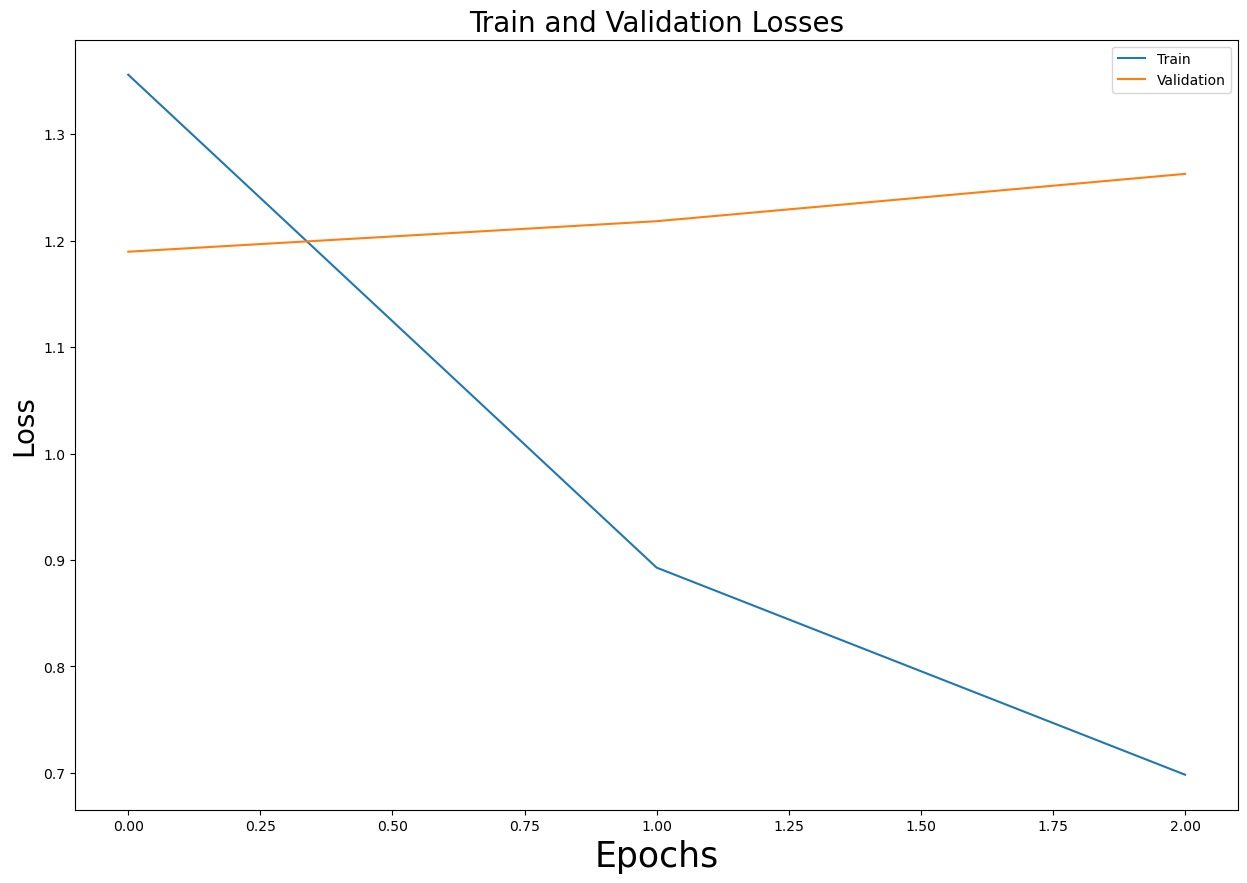

In [13]:
%%time

from matplotlib import pyplot as plt

# Plotting the train and validation losses

fig, ax = plt.subplots(1, 1, figsize=(15, 10))

ax.set_title('Train and Validation Losses', size=20)
ax.set_ylabel('Loss', fontsize=20)
ax.set_xlabel('Epochs', fontsize=25)
_ = ax.plot(train_losses)
_ = ax.plot(validation_losses)
_ = ax.legend(('Train', 'Validation'), loc='upper right')